In [1]:
import os
import json
import warnings
import random

import dgl
import torch
import torch_geometric as tg

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn

from graphlime import GraphLIME
from mumin import MuminDataset

import torchmetrics as tm

from tqdm.notebook import tqdm
from collections import defaultdict

from torch_geometric.data import Data as tgData

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from mumin_explainable.architectures.graphs import GAT
from mumin_explainable.processor.tweetnormalizer import normalizeTweet

from dotenv import load_dotenv

import mlflow


%matplotlib inline

warnings.filterwarnings('ignore')
_= torch.manual_seed(42)

/home/vlourenco/anaconda3/envs/phd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vlourenco/anaconda3/envs/phd/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Setup mumin graph

In [2]:
size= 'small'

dataset_mumin = MuminDataset(
    twitter_bearer_token=os.getenv('TWITTER_BEARER_TOKEN'),
    size=size,
    dataset_path=f'./data/datasets/mumin-{size}.zip'
)
dataset_mumin.compile()
mumin_graph = dataset_mumin.to_dgl()
mumin_graph

2023-05-06 16:46:57,324 [INFO] Loading dataset
2023-05-06 16:47:20,311 [INFO] Outputting to DGL


Graph(num_nodes={'article': 1446, 'claim': 2083, 'hashtag': 27802, 'image': 1015, 'reply': 177816, 'tweet': 4061, 'user': 152038},
      num_edges={('article', 'has_article_inv', 'tweet'): 1890, ('claim', 'discusses_inv', 'tweet'): 4749, ('hashtag', 'has_hashtag_inv', 'tweet'): 2284, ('hashtag', 'has_hashtag_inv', 'user'): 49626, ('image', 'has_image_inv', 'tweet'): 1019, ('reply', 'posted_inv', 'user'): 177816, ('reply', 'quote_of', 'tweet'): 88495, ('reply', 'reply_to', 'tweet'): 78576, ('tweet', 'discusses', 'claim'): 4749, ('tweet', 'has_article', 'article'): 1890, ('tweet', 'has_hashtag', 'hashtag'): 2284, ('tweet', 'has_image', 'image'): 1019, ('tweet', 'mentions', 'user'): 1112, ('tweet', 'posted_inv', 'user'): 4061, ('tweet', 'quote_of_inv', 'reply'): 88495, ('tweet', 'reply_to_inv', 'reply'): 78576, ('tweet', 'retweeted_inv', 'user'): 12800, ('user', 'follows', 'user'): 17974, ('user', 'follows_inv', 'user'): 17974, ('user', 'has_hashtag', 'hashtag'): 49626, ('user', 'mentions

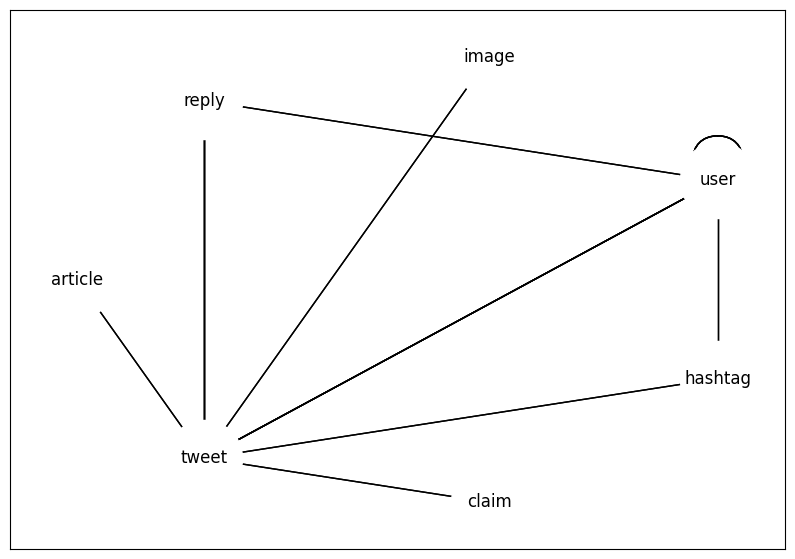

In [3]:
plt.figure(figsize=(10, 7))
metagraph = mumin_graph.metagraph()
nx.draw_networkx(metagraph, 
                 pos=nx.shell_layout(metagraph), 
                 node_color='white', 
                 node_size=3000,
                 arrows=False)

In [4]:
user_df = dataset_mumin.nodes['user']
tweet_df = dataset_mumin.nodes['tweet']

user_posted_tweet_df = dataset_mumin.rels[('user', 'posted', 'tweet')]

# user_df.dropna(inplace=True)
# claim_df.dropna(inplace=True)
# tweet_df.dropna(inplace=True)

# Setup subgraph

In [5]:
user_posted_tweet_subgraph = dgl.edge_type_subgraph(mumin_graph, etypes=[('user', 'posted', 'tweet')])

## Filter language

In [6]:
LANG = 'multilingual'
tweet_ds_copy = dataset_mumin.nodes['tweet'].dropna()
lang_tweets = (tweet_ds_copy['lang'] == LANG).to_list()
del(tweet_ds_copy)

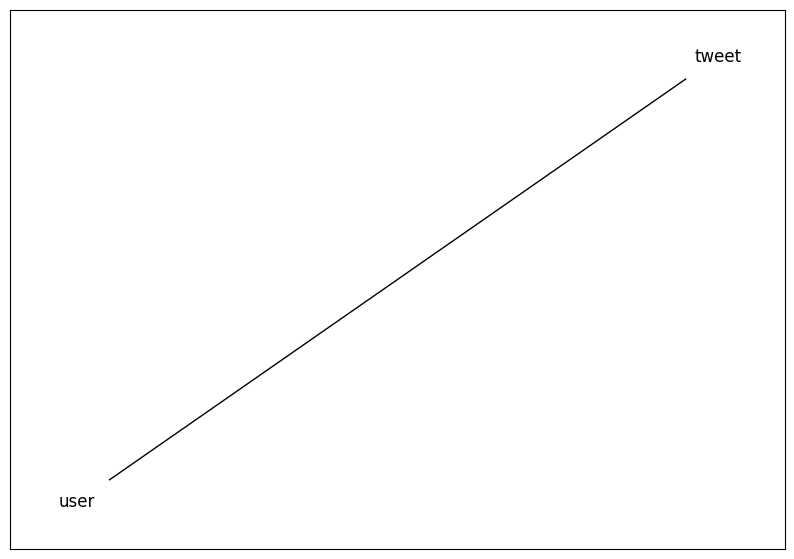

In [7]:
if LANG == 'multilingual':
    lang_tweets = [True] * len(lang_tweets)
tweet_train_mask = user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets)
tweet_val_mask = user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets)
tweet_test_mask = user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets)

plt.figure(figsize=(10, 7))
user_posted_tweet_metagraph = user_posted_tweet_subgraph.metagraph()
nx.draw_networkx(user_posted_tweet_metagraph, 
                 pos=nx.shell_layout(user_posted_tweet_metagraph), 
                 node_color='white', 
                 node_size=3000,
                 arrows=False)

# Setup dataset

In [8]:
edges_index = torch.cat([
    user_posted_tweet_subgraph.edges(etype='posted')[0].unsqueeze(0),
    user_posted_tweet_subgraph.edges(etype='posted')[1].unsqueeze(0)
], dim=0)
data = tgData(
    x=user_posted_tweet_subgraph.nodes['tweet'].data['feat'],
    y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
    train_mask=tweet_train_mask,
    val_mask=tweet_val_mask,
    test_mask=tweet_test_mask,
    edge_index=edges_index.long())

# Train GAT

In [9]:
MODEL_NAME = f'{LANG}_graph'
hparams = {
    'input_dim': data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(data.y).item() + 1
}

model = GAT(**hparams).double()

lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
best_f1macro = -1

bootstrap = tm.BootStrapper(
    f1_score, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(data.x, data.edge_index)
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    f1 = f1_score(output[data.train_mask], data.y[data.train_mask])
    f1macro = torch.mean(f1)

    bootstrap.update(output[data.train_mask], data.y[data.train_mask])

    if f1macro > best_f1macro:
        best_f1macro = f1macro
        torch.save(model.state_dict(), f'./data/models/{MODEL_NAME}.pth')

    if epoch % 10 == 0:
        metrics = {
            'Epoch': epoch,
            'Accuracy': accuracy(output[data.train_mask], data.y[data.train_mask]),
            'Precision': precision(output[data.train_mask], data.y[data.train_mask]),
            'Recall': recall(output[data.train_mask], data.y[data.train_mask]),
            'Stats_Score': stats_score(output[data.train_mask], data.y[data.train_mask]),
            'F1': f1,
            'F1-macro': f1macro,
            'Bootstrap': bootstrap.compute()
        }
        print(metrics)

  0%|          | 0/400 [00:00<?, ?it/s]

{'Epoch': 0, 'Accuracy': tensor([0.6891, 0.3434]), 'Precision': tensor([0.9063, 0.1070]), 'Recall': tensor([0.6891, 0.3434]), 'Stats_Score': tensor([[1886,  195,  102,  851, 2737],
        [ 102,  851, 1886,  195,  297]]), 'F1': tensor([0.7829, 0.1632]), 'F1-macro': tensor(0.4730), 'Bootstrap': {'mean': tensor([0.7822, 0.1634]), 'std': tensor([0.0063, 0.0145]), 'quantile': tensor([0.1457, 0.7901])}}
{'Epoch': 10, 'Accuracy': tensor([0.9883, 0.0269]), 'Precision': tensor([0.9035, 0.2000]), 'Recall': tensor([0.9883, 0.0269]), 'Stats_Score': tensor([[2705,  289,    8,   32, 2737],
        [   8,   32, 2705,  289,  297]]), 'F1': tensor([0.9440, 0.0475]), 'F1-macro': tensor(0.4957), 'Bootstrap': {'mean': tensor([0.9112, 0.0779]), 'std': tensor([0.0010, 0.0048]), 'quantile': tensor([0.0727, 0.9125])}}
{'Epoch': 20, 'Accuracy': tensor([0.9781, 0.0101]), 'Precision': tensor([0.9010, 0.0476]), 'Recall': tensor([0.9781, 0.0101]), 'Stats_Score': tensor([[2677,  294,    3,   60, 2737],
        [  

In [10]:
model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model.eval()

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')

print('test')

f1 = f1_score(output[data.test_mask], data.y[data.test_mask])
f1macro = torch.mean(f1)

metrics = {
    'Accuracy': accuracy(output[data.test_mask], data.y[data.test_mask]),
    'Precision': precision(output[data.test_mask], data.y[data.test_mask]),
    'Recall': recall(output[data.test_mask], data.y[data.test_mask]),
    'Stats_Score': stats_score(output[data.test_mask], data.y[data.test_mask]),
    'F1': f1,
    'F1-macro': f1macro,
    'Bootstrap': bootstrap.compute()
}

print(metrics)

test
{'Accuracy': tensor([0.9880, 0.0000]), 'Precision': tensor([0.9493, 0.0000]), 'Recall': tensor([0.9880, 0.0000]), 'Stats_Score': tensor([[412,  22,   0,   5, 417],
        [  0,   5, 412,  22,  22]]), 'F1': tensor([0.9683, 0.0000]), 'F1-macro': tensor(0.4841), 'Bootstrap': {'mean': tensor([0.9402, 0.0304]), 'std': tensor([0.0002, 0.0007]), 'quantile': tensor([0.0295, 0.9404])}}


In [11]:
model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model.eval()

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
acc_bs = tm.BootStrapper(
    accuracy, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
f1_bs = tm.BootStrapper(
    f1_score, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

acc_bs.update(output[data.test_mask], data.y[data.test_mask])
f1_bs.update(output[data.test_mask], data.y[data.test_mask])

out_acc_bs = acc_bs.compute()
out_f1_bs = f1_bs.compute()

results = {
    'Language': LANG,
    'Accuracy Bootstrap': out_acc_bs,
    'F1 Bootstrap': out_f1_bs
}

print(results)

{'Language': 'multilingual', 'Accuracy Bootstrap': {'mean': tensor([0.9875, 0.0000]), 'std': tensor([0.0054, 0.0000]), 'quantile': tensor([0.0000, 0.9929])}, 'F1 Bootstrap': {'mean': tensor([0.9682, 0.0000]), 'std': tensor([0.0063, 0.0000]), 'quantile': tensor([0.0000, 0.9755])}}


In [12]:
def get_all_nodes_explanation(model, explainer, data, dataset_mumin):

    feature_id_map = {
        'num_retweets': 0,
        'num_replies': 1,
        'num_quote_tweets': 2
    }

    user_df = dataset_mumin.nodes['user']
    tweet_df = dataset_mumin.nodes['tweet']
    reply_df = dataset_mumin.nodes['reply']

    reply_quoteof_tweet_df = dataset_mumin.rels[('reply', 'quote_of', 'tweet')]
    reply_quoteof_tweet_df = (reply_df.merge(reply_quoteof_tweet_df, left_index=True, right_on='src')
                            .merge(tweet_df, left_on='tgt', right_index=True)
                            .reset_index(drop=True))

    user_posted_tweet_df = dataset_mumin.rels[('user', 'posted', 'tweet')]
    user_posted_tweet_df = (user_df.merge(user_posted_tweet_df, left_index=True, right_on='src')
                            .merge(tweet_df, left_on='tgt', right_index=True)
                            .reset_index(drop=True))

    user_posted_reply_df = dataset_mumin.rels[('user', 'posted', 'reply')]
    user_posted_reply_df = (user_df.merge(user_posted_reply_df, left_index=True, right_on='src')
                            .merge(tweet_df, left_on='tgt', right_index=True)
                            .reset_index(drop=True))

    for node_idx in range(data.x.shape[0]):
        
        coefs = explainer.explain_node(node_idx, data.x, data.edge_index)
        probas = model(data.x, data.edge_index).exp()
        # fact_or_fake = 'fact' if torch.argmax(probas[node_idx]).item() == 0 else 'fake'

        if tweet_df.iloc[node_idx]['num_quote_tweets'] != 0 and \
            feature_id_map['num_quote_tweets'] not in list(np.where(coefs != 0)[0]): # get only inferences explained by quotes

            tgt_tweet_id = dataset_mumin.nodes['tweet'].iloc[node_idx]['tweet_id']

            # manual traverse
            replies_src = list(reply_quoteof_tweet_df.query(f'tweet_id_y == {tgt_tweet_id}')['src'])                      
            quoters_ids = list(user_posted_reply_df.query(f'tgt in {str(replies_src)}')['user_id'])
            quoters_posts = user_posted_tweet_df[user_posted_tweet_df['user_id'].isin(quoters_ids)]

            if not quoters_posts.empty:
                # print(fact_or_fake, quoters_ids)
                print(quoters_ids)
                # break

In [13]:
# user_df = dataset_mumin.nodes['user']
# explainer = GraphLIME(model, hop=2, rho=0.1, cached=True)
# get_all_nodes_explanation(model, explainer, data, dataset_mumin)

# Enhance with text-based features

In [14]:
from transformers import AutoModelForSequenceClassification

TEXT_DIM = 100

LANG_TOOL_MAP = {
    'multilingual': {
        'bertweet': AutoModel.from_pretrained('vinai/bertweet-base'),
        'tokenizer': AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)
    },
    'en': {
        'bertweet': AutoModel.from_pretrained('vinai/bertweet-base'),
        'tokenizer': AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)
    },
    'pt': {
        'bertweet': AutoModel.from_pretrained('melll-uff/bertweetbr'),
        'tokenizer': AutoTokenizer.from_pretrained('melll-uff/bertweetbr', normalization=True)
    },
    'es': {
        'bertweet': AutoModel.from_pretrained('pysentimiento/robertuito-base-cased'),
        'tokenizer': AutoTokenizer.from_pretrained('pysentimiento/robertuito-base-cased')
    }
}

bertweet = LANG_TOOL_MAP[LANG]['bertweet']
tokenizer = LANG_TOOL_MAP[LANG]['tokenizer']

# bertweet = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)
# bertweet = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)

In [15]:
def tweetencoder(x, text_dim):
    try:
        x = bertweet(torch.tensor([tokenizer.encode(normalizeTweet(x))])).pooler_output
    except:
        # print(x)
        x = bertweet(torch.tensor([tokenizer.encode('')])).pooler_output
    return nn.Linear(768, text_dim)(x).tolist()[0]
    # return x

In [16]:
tweet_df['text_encoding'] = str([0] * TEXT_DIM)
if LANG == 'multilingual':
    tweet_df['text_encoding'] = [tweetencoder(text, TEXT_DIM) for text in tweet_df['text']]
else:
    tweet_df['text_encoding'] = [tweetencoder(text, TEXT_DIM) if lang == LANG else str([0] * TEXT_DIM) for text,lang in zip(tweet_df['text'], tweet_df['lang'])]

In [17]:
new_embedding_columns = [f'emb{i}' for i in range(TEXT_DIM)]

tweet_embeddings_split_df = pd.DataFrame(
    [x if not isinstance(x, str) else eval(x) for x in tweet_df['text_encoding'].tolist()],
    index=tweet_df.index,
    columns=new_embedding_columns
)
tweet_df = pd.concat([tweet_df, tweet_embeddings_split_df], axis=1)
tweet_df.dropna(inplace=True)
display(tweet_df)

,tweet_id,text,created_at,lang,source,num_retweets,num_replies,num_quote_tweets,text_emb,lang_emb,...,emb90,emb91,emb92,emb93,emb94,emb95,emb96,emb97,emb98,emb99
0,1238947475471454220,Antes de llegar a los pulmones dura 4 días en ...,2020-03-14 21:57:51,es,Twitter for Android,8,3,0,"[-0.0467078, 0.25795, 0.119816095, 0.4975067, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",...,-0.030432,0.047479,0.116153,0.062141,0.129011,0.191782,0.348272,0.050009,0.239785,0.057194
1,1295062953000042496,Aeroporto de Dubai em chamas. 🤕😧 https://t.co/...,2020-08-16 18:20:43,pt,Twitter for Android,6,0,5,"[-0.04832051, 0.22119147, 0.10080599, 0.506648...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.056666,-0.014677,-0.031088,-0.045335,-0.034855,-0.121806,-0.059985,0.173999,0.035268,0.001431
2,1294614020008312832,Fogo 🔥 no aeroporto de Dubai 😱😱 https://t.co/2...,2020-08-15 12:36:49,pt,Twitter for Android,24,11,7,"[-0.049368992, 0.20724605, 0.09472715, 0.51769...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.081485,0.079394,0.078704,-0.132329,0.128309,0.053484,-0.066028,-0.054567,-0.171050,-0.000837
3,1294701863489744896,Fogo no aeroporto de Dubai. https://t.co/yhQDe...,2020-08-15 18:25:53,pt,Twitter for Android,15,7,4,"[-0.054105558, 0.22766814, 0.09675161, 0.51384...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.110041,0.048448,-0.001868,0.028781,0.088543,-0.075061,0.186520,0.175818,0.011049,0.053987
4,1295124644085805057,Incendio en el aeropuerto de Dubai https://t.c...,2020-08-16 22:25:52,es,Twitter for Android,33,5,3,"[-0.043678686, 0.23453882, 0.11631639, 0.50836...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",...,0.123665,0.026915,-0.168271,0.052670,0.047151,0.093792,-0.026337,-0.136947,-0.068922,0.123668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,783488210454376448,"Yes, @ClintonFdn has accepted millions from f...",2016-10-05 02:05:20,en,Twitter Web Client,270,10,3,"[-0.055992845, 0.23851915, 0.12183203, 0.51381...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",...,0.207220,-0.106658,0.037158,0.018362,0.020756,-0.072450,-0.075793,0.179442,0.046112,-0.066791
4057,783486380777373696,"#VPDebate fact check: Yes, the Clinton Foundat...",2016-10-05 01:58:04,en,SocialFlow,227,23,23,"[-0.066264085, 0.2269559, 0.11466829, 0.508162...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",...,0.103628,-0.202360,0.016626,-0.038071,-0.077659,-0.037691,-0.061104,0.010067,-0.041747,-0.062069
4058,783493825931206656,"Yes, the Clinton Foundation has accepted milli...",2016-10-05 02:27:39,en,Twitter Web Client,6,0,1,"[-0.054452505, 0.23137671, 0.1135482, 0.503517...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.041481,-0.139384,-0.083523,0.122343,-0.009795,0.192462,0.038140,0.011665,-0.065758,-0.041241
4059,1337737596881911809,📌 สถานการณ์โรคติดเชื้อไวรัสโคโรนา 2019 (COVID-...,2020-12-12 12:34:31,th,Twitter for Android,39,0,5,"[-0.06284507, 0.2391499, 0.11289272, 0.5124814...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.012350,0.061729,0.054183,0.095843,0.101495,0.051854,-0.135178,0.159492,0.027678,0.016564


In [18]:
MODE = 'multimodal'
# MODE = 'text'

new_features_df = pd.DataFrame(index=range(user_posted_tweet_subgraph.nodes['tweet'].data['feat'].shape[0]))
new_features_df = new_features_df.join(tweet_df[new_embedding_columns])#.fillna(0)
new_features_tensor = torch.tensor(new_features_df.values).double()

mixed_features = new_features_tensor
if MODE == 'multimodal':
    mixed_features = torch.cat([user_posted_tweet_subgraph.nodes['tweet'].data['feat'], new_features_tensor], axis = 1).double()

edges_index = torch.cat([
    user_posted_tweet_subgraph.edges(etype='posted')[0].unsqueeze(0),
    user_posted_tweet_subgraph.edges(etype='posted')[1].unsqueeze(0)
], dim=0)
new_features_data = tgData(
    x=mixed_features,
    y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
    train_mask=user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets),
    val_mask=user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets),
    test_mask=user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets),
    edge_index=edges_index.long())

In [19]:
hparams = {
    'input_dim': new_features_data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(new_features_data.y).item() + 1
}

MODEL_NAME = f'{LANG}_{MODE}'

model = GAT(**hparams).double()

lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
best_f1macro = -1

bootstrap = tm.BootStrapper(
    f1_score, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(new_features_data.x, new_features_data.edge_index)
    loss = F.nll_loss(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    f1 = f1_score(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask])
    f1macro = torch.mean(f1)

    bootstrap.update(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask])

    if f1macro > best_f1macro:
        best_f1macro = f1macro
        torch.save(model.state_dict(), f'./data/models/{MODEL_NAME}.pth')

    if epoch % 10 == 0:
        metrics = {
            'Epoch': epoch,
            'Accuracy': accuracy(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask]),
            'Precision': precision(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask]),
            'Recall': recall(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask]),
            'Stats_Score': stats_score(output[new_features_data.train_mask], new_features_data.y[new_features_data.train_mask]),
            'F1': f1,
            'F1-macro': f1macro,
            'Bootstrap': bootstrap.compute()
        }
        print(metrics)

model.eval()

  0%|          | 0/400 [00:00<?, ?it/s]

{'Epoch': 0, 'Accuracy': tensor([0.6047, 0.3535]), 'Precision': tensor([0.8960, 0.0885]), 'Recall': tensor([0.6047, 0.3535]), 'Stats_Score': tensor([[1655,  192,  105, 1082, 2737],
        [ 105, 1082, 1655,  192,  297]]), 'F1': tensor([0.7221, 0.1415]), 'F1-macro': tensor(0.4318), 'Bootstrap': {'mean': tensor([0.7215, 0.1411]), 'std': tensor([0.0075, 0.0120]), 'quantile': tensor([0.1263, 0.7308])}}
{'Epoch': 10, 'Accuracy': tensor([0.9547, 0.0572]), 'Precision': tensor([0.9032, 0.1206]), 'Recall': tensor([0.9547, 0.0572]), 'Stats_Score': tensor([[2613,  280,   17,  124, 2737],
        [  17,  124, 2613,  280,  297]]), 'F1': tensor([0.9282, 0.0776]), 'F1-macro': tensor(0.5029), 'Bootstrap': {'mean': tensor([0.9126, 0.0796]), 'std': tensor([0.0011, 0.0048]), 'quantile': tensor([0.0735, 0.9139])}}
{'Epoch': 20, 'Accuracy': tensor([0.9185, 0.0909]), 'Precision': tensor([0.9030, 0.1080]), 'Recall': tensor([0.9185, 0.0909]), 'Stats_Score': tensor([[2514,  270,   27,  223, 2737],
        [  

GAT(
  (conv1): GATConv(912, 2, heads=8)
  (conv2): GATConv(16, 2, heads=1)
)

In [20]:
model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model.eval()

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')

print('test')

output = model(new_features_data.x, new_features_data.edge_index)

f1 = f1_score(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask])
f1macro = torch.mean(f1)

metrics = {
    'Accuracy': accuracy(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask]),
    'Precision': precision(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask]),
    'Recall': recall(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask]),
    'Stats_Score': stats_score(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask]),
    'F1': f1,
    'F1-macro': f1macro,
    'Bootstrap': bootstrap.compute()
}

print(metrics)

test
{'Accuracy': tensor([1., 0.]), 'Precision': tensor([0.9499, 0.0000]), 'Recall': tensor([1., 0.]), 'Stats_Score': tensor([[417,  22,   0,   0, 417],
        [  0,   0, 417,  22,  22]]), 'F1': tensor([0.9743, 0.0000]), 'F1-macro': tensor(0.4871), 'Bootstrap': {'mean': tensor([0.9453, 0.0127]), 'std': tensor([0.0001, 0.0004]), 'quantile': tensor([0.0122, 0.9455])}}


In [21]:
model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model.eval()

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
acc_bs = tm.BootStrapper(
    accuracy, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
f1_bs = tm.BootStrapper(
    f1_score, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)


output = model(new_features_data.x, new_features_data.edge_index)

acc_bs.update(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask])
f1_bs.update(output[new_features_data.test_mask], new_features_data.y[new_features_data.test_mask])

out_acc_bs = acc_bs.compute()
out_f1_bs = f1_bs.compute()

results = {
    'Language': LANG,
    'Accuracy Bootstrap': out_acc_bs,
    'F1 Bootstrap': out_f1_bs
}

print(results)

{'Language': 'multilingual', 'Accuracy Bootstrap': {'mean': tensor([1., 0.]), 'std': tensor([0., 0.]), 'quantile': tensor([0., 1.])}, 'F1 Bootstrap': {'mean': tensor([0.9738, 0.0000]), 'std': tensor([0.0054, 0.0000]), 'quantile': tensor([0.0000, 0.9803])}}


# Trustworthy?

In [98]:
MODEL_NAME = f'{LANG}_{MODE}'

model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model.eval()

print('test original_features')

original_features_classification_output = model(new_features_data.x, new_features_data.edge_index)
probas = original_features_classification_output.exp()
original_pred_label = torch.argmax(probas, dim=1)

test original_features


## Filter features

In [99]:
trustworthy_features_list = random.sample(range(new_features_data.x.shape[1]), k=int(new_features_data.x.shape[1] * 0.7))
untrustworthy_features_list = [i for i in range(new_features_data.x.shape[1]) if i not in trustworthy_features_list]

trustworthy_features = new_features_data.x[:, trustworthy_features_list]
untrustworthy_features = new_features_data.x[:, untrustworthy_features_list]

trustworthy_features_data = tgData(
    x=trustworthy_features,
    y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
    train_mask=user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets),
    val_mask=user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets),
    test_mask=user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets),
    edge_index=edges_index.long())

In [102]:
hparams = {
    'input_dim': trustworthy_features_data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(trustworthy_features_data.y).item() + 1
}

MODEL_NAME = f'{LANG}_{MODE}_filtered'

model_filtered = GAT(**hparams).double()

lr = 0.005
epochs = 400

model_filtered.train()
optimizer = optim.Adam(model_filtered.parameters(), lr=lr)

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
best_f1macro = -1

bootstrap = tm.BootStrapper(
    f1_score, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model_filtered(trustworthy_features_data.x, trustworthy_features_data.edge_index)
    loss = F.nll_loss(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    f1 = f1_score(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask])
    f1macro = torch.mean(f1)

    bootstrap.update(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask])

    if f1macro > best_f1macro:
        best_f1macro = f1macro
        torch.save(model_filtered.state_dict(), f'./data/models/{MODEL_NAME}.pth')

    if epoch % 10 == 0:
        metrics = {
            'Epoch': epoch,
            'Accuracy': accuracy(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask]),
            'Precision': precision(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask]),
            'Recall': recall(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask]),
            'Stats_Score': stats_score(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask]),
            'F1': f1,
            'F1-macro': f1macro,
            'Bootstrap': bootstrap.compute()
        }
        print(metrics)

model_filtered.eval()

  0%|          | 0/400 [00:00<?, ?it/s]

{'Epoch': 0, 'Accuracy': tensor([0.6781, 0.3367]), 'Precision': tensor([0.9040, 0.1019]), 'Recall': tensor([0.6781, 0.3367]), 'Stats_Score': tensor([[1856,  197,  100,  881, 2737],
        [ 100,  881, 1856,  197,  297]]), 'F1': tensor([0.7749, 0.1565]), 'F1-macro': tensor(0.4657), 'Bootstrap': {'mean': tensor([0.7759, 0.1556]), 'std': tensor([0.0072, 0.0141]), 'quantile': tensor([0.1392, 0.7848])}}
{'Epoch': 10, 'Accuracy': tensor([0.9868, 0.0101]), 'Precision': tensor([0.9018, 0.0769]), 'Recall': tensor([0.9868, 0.0101]), 'Stats_Score': tensor([[2701,  294,    3,   36, 2737],
        [   3,   36, 2701,  294,  297]]), 'F1': tensor([0.9424, 0.0179]), 'F1-macro': tensor(0.4801), 'Bootstrap': {'mean': tensor([0.9278, 0.0743]), 'std': tensor([0.0011, 0.0054]), 'quantile': tensor([0.0679, 0.9292])}}
{'Epoch': 20, 'Accuracy': tensor([0.9160, 0.0673]), 'Precision': tensor([0.9005, 0.0800]), 'Recall': tensor([0.9160, 0.0673]), 'Stats_Score': tensor([[2507,  277,   20,  230, 2737],
        [  

GAT(
  (conv1): GATConv(638, 2, heads=8)
  (conv2): GATConv(16, 2, heads=1)
)

In [103]:
model_filtered.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model_filtered.eval()

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')

print('test')

output = model_filtered(trustworthy_features_data.x, trustworthy_features_data.edge_index)

f1 = f1_score(output[trustworthy_features_data.test_mask], trustworthy_features_data.y[trustworthy_features_data.test_mask])
f1macro = torch.mean(f1)

metrics = {
    'Accuracy': accuracy(output[trustworthy_features_data.test_mask], trustworthy_features_data.y[trustworthy_features_data.test_mask]),
    'Precision': precision(output[new_features_data.test_mask], trustworthy_features_data.y[trustworthy_features_data.test_mask]),
    'Recall': recall(output[trustworthy_features_data.test_mask], trustworthy_features_data.y[trustworthy_features_data.test_mask]),
    'Stats_Score': stats_score(output[trustworthy_features_data.test_mask], trustworthy_features_data.y[trustworthy_features_data.test_mask]),
    'F1': f1,
    'F1-macro': f1macro,
    'Bootstrap': bootstrap.compute()
}

print(metrics)

test
{'Accuracy': tensor([0.9832, 0.0000]), 'Precision': tensor([0.9491, 0.0000]), 'Recall': tensor([0.9832, 0.0000]), 'Stats_Score': tensor([[410,  22,   0,   7, 417],
        [  0,   7, 410,  22,  22]]), 'F1': tensor([0.9658, 0.0000]), 'F1-macro': tensor(0.4829), 'Bootstrap': {'mean': tensor([0.9466, 0.0096]), 'std': tensor([0.0001, 0.0004]), 'quantile': tensor([0.0092, 0.9468])}}


In [104]:
MODEL_NAME = f'{LANG}_{MODE}_filtered'

model_filtered.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model_filtered.eval()

print('test trustworthy_features')

trustworthy_features_classification_output = model_filtered(trustworthy_features_data.x, trustworthy_features_data.edge_index)
trustworthy_pred_label = torch.argmax(trustworthy_features_classification_output.exp(), dim=1)

test trustworthy_features


In [105]:
np.where((original_pred_label == trustworthy_pred_label).numpy() == False)[0].shape, np.where((original_pred_label == trustworthy_pred_label).numpy() == True)[0].shape

((317,), (3744,))

In [173]:
explainer_original = GraphLIME(model, hop=2, rho=0.1, cached=True)
explainer_filtered = GraphLIME(model_filtered, hop=2, rho=0.1, cached=True)

count_untrustworthy = 0
for i in list(np.stack(np.argwhere((original_pred_label == trustworthy_pred_label).numpy() == False),axis=1)[0]):
    
    coefs_original = explainer_original.explain_node(int(i), new_features_data.x, new_features_data.edge_index)
    coefs_filtered = explainer_filtered.explain_node(int(i), trustworthy_features_data.x, trustworthy_features_data.edge_index)
    
    count_untrustworthy += 1 if np.where(coefs_original != 0)[0].shape == np.where(coefs_filtered != 0)[0].shape else 0

count_trustworthy = int(np.stack(np.argwhere((original_pred_label == trustworthy_pred_label).numpy() == False),axis=1)[0].shape[0]) - count_untrustworthy
print(count_untrustworthy, count_trustworthy)

100 - count_untrustworthy/len(original_pred_label)*100, 100 - count_trustworthy/len(original_pred_label)*100

222 95


(94.53336616596897, 97.66067471066239)

In [27]:
explainer_original = GraphLIME(model, hop=2, rho=0.1, cached=True)

with open('count_untrustworthy.txt', 'w') as f:
    f.write('idx,count_untrustworthy,count_trustworthy\n')

MODEL_NAME = f'{LANG}_{MODE}_filtered'
lr = 0.005
epochs = 400
MAX_SAMPLES = 100

for sample_iter in tqdm(range(MAX_SAMPLES)):
    trustworthy_features_list = random.sample(range(new_features_data.x.shape[1]), k=int(new_features_data.x.shape[1] * 0.7))
    untrustworthy_features_list = [i for i in range(new_features_data.x.shape[1]) if i not in trustworthy_features_list]

    trustworthy_features = new_features_data.x[:, trustworthy_features_list]
    untrustworthy_features = new_features_data.x[:, untrustworthy_features_list]

    trustworthy_features_data = tgData(
        x=trustworthy_features,
        y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
        train_mask=user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets),
        val_mask=user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets),
        test_mask=user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets),
        edge_index=edges_index.long())

    hparams = {
        'input_dim': trustworthy_features_data.num_node_features,
        'hidden_dim': 16,
        'output_dim': max(trustworthy_features_data.y).item() + 1
    }

    model_filtered = GAT(**hparams).double()

    model_filtered.train()
    optimizer = optim.Adam(model_filtered.parameters(), lr=lr)

    f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
    best_f1macro = -1

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        output = model_filtered(trustworthy_features_data.x, trustworthy_features_data.edge_index)
        loss = F.nll_loss(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask])
        
        loss.backward()
        optimizer.step()
        
        f1 = f1_score(output[trustworthy_features_data.train_mask], trustworthy_features_data.y[trustworthy_features_data.train_mask])
        f1macro = torch.mean(f1)

        if f1macro > best_f1macro:
            best_f1macro = f1macro
            torch.save(model_filtered.state_dict(), f'./data/models/{MODEL_NAME}.pth')

    model_filtered.eval()

    trustworthy_features_classification_output = model_filtered(trustworthy_features_data.x, trustworthy_features_data.edge_index)
    trustworthy_pred_label = torch.argmax(trustworthy_features_classification_output.exp(), dim=1)

    explainer_filtered = GraphLIME(model_filtered, hop=2, rho=0.1, cached=True)

    count_untrustworthy = 0
    for i in list(np.stack(np.argwhere((original_pred_label == trustworthy_pred_label).numpy() == False),axis=1)[0]):
        
        coefs_original = explainer_original.explain_node(int(i), new_features_data.x, new_features_data.edge_index)
        coefs_filtered = explainer_filtered.explain_node(int(i), trustworthy_features_data.x, trustworthy_features_data.edge_index)
        
        count_untrustworthy += 1 if np.where(coefs_original != 0)[0].shape == np.where(coefs_filtered != 0)[0].shape else 0

    count_trustworthy = int(np.stack(np.argwhere((original_pred_label == trustworthy_pred_label).numpy() == False),axis=1)[0].shape[0]) - count_untrustworthy

    result_count_untrustworthy = 100 - count_untrustworthy/len(original_pred_label)
    result_count_trustworthy = 100 - count_trustworthy/len(original_pred_label)
    with open('count_untrustworthy.txt', 'a') as f:
        f.write(f'{sample_iter},{result_count_untrustworthy},{result_count_trustworthy}\n')

f.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [147]:
coefs_original = explainer_original.explain_node(25, new_features_data.x, new_features_data.edge_index)
coefs_filtered = explainer_filtered.explain_node(25, trustworthy_features_data.x, trustworthy_features_data.edge_index)

In [168]:
np.where(coefs_original != 0)[0].shape == np.where(coefs_filtered != 0)[0].shape

True

In [23]:
explainer = GraphLIME(model, hop=2, rho=0.1, cached=True)

for i in new_features_data.test_mask.nonzero().view(-1).tolist():
    coefs = explainer.explain_node(i, new_features_data.x, new_features_data.edge_index)
    if np.where(coefs != 0)[0].tolist() != []:
        print(i)
        print(coefs)
        break

74
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.13086845 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

In [ ]:
explainer = GraphLIME(model, hop=2, rho=0.1, cached=False)

probas = model(new_features_data.x, new_features_data.edge_index).exp()
coefs = explainer.explain_node(2, new_features_data.x, new_features_data.edge_index)
print(coefs, len(coefs))
print(np.where(coefs != 0))
np.where(coefs != 0)


In [ ]:
# list(tweet_df[tweet_df['lang'] == 'pt'].index)

In [ ]:
explainer = GraphLIME(model, hop=2, rho=0.1, cached=True)

# for node_idx in range(data.x.shape[0]):
#     coefs = explainer.explain_node(node_idx, data.x, data.edge_index)
#     if len(set(np.where(coefs != 0)[0]).intersection(set([3,4,5]))) != 0:
#         print(node_idx)

# try: 102 | 118 | 127
node_idx = 91

probas = model(new_features_data.x, new_features_data.edge_index).exp()
print(probas[node_idx], torch.argmax(probas[node_idx]).item())
coefs = explainer.explain_node(node_idx, new_features_data.x, new_features_data.edge_index)

print(coefs, len(coefs))
print(np.where(coefs != 0))

In [ ]:
k = 91
print(tweet_df.loc[k].text)
tweet_df.loc[k]

In [ ]:
tweet_df = dataset_mumin.nodes['tweet']
claim_df = dataset_mumin.nodes['claim']
x = dataset_mumin.rels[('tweet', 'discusses', 'claim')]
y = (tweet_df.merge(x, left_index=True, right_on='src')
                          .merge(claim_df, left_on='tgt', right_index=True)
                          .reset_index(drop=True))

y[y['tweet_id'] == 1334273990039375876]

In [ ]:
tweet_df = dataset_mumin.nodes['tweet']
reply_df = dataset_mumin.nodes['reply']
reply_quoteof_tweet_df = dataset_mumin.rels[('reply', 'reply_to', 'tweet')]
reply_quoteof_tweet_df = (reply_df.merge(quote_of_df, left_index=True, right_on='src')
                        .merge(tweet_df, left_on='tgt', right_index=True)
                        .reset_index(drop=True))

reply_quoteof_tweet_df[reply_quoteof_tweet_df['tweet_id_y'] == 1334273990039375876]

In [ ]:
from transformers_interpret import SequenceClassificationExplainer, MultiLabelClassificationExplainer
# cls_explainer = SequenceClassificationExplainer(bertweet,tokenizer)
cls_explainer = SequenceClassificationExplainer(bertweet,tokenizer)

In [ ]:
word_attributions = cls_explainer(normalizeTweet(tweet_df.loc[127].text))

In [ ]:
cls_explainer.predicted_class_name

In [ ]:
cls_explainer.visualize()

In [ ]:
word_attributions = cls_explainer(normalizeTweet('Head of Pfizer Research: Covid Vaccine is Female Sterilization – Health and Money News https://t.co/IDRLSVmkLz'))

In [ ]:
cls_explainer.visualize()

In [ ]:
bertweet = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=2)
F.softmax(bertweet(torch.tensor([tokenizer.encode(normalizeTweet('my favourite text'))])).logits)

In [ ]:
F.softmax(bertweet(torch.tensor([tokenizer.encode(normalizeTweet('my favourite text'))])).logits, dim=1)

In [ ]:
cls_explainer = SequenceClassificationExplainer(bertweet,tokenizer)

In [ ]:
word_attributions = cls_explainer(normalizeTweet(tweet_df.loc[102].text))
cls_explainer.visualize()

In [ ]:
dataset_mumin.nodes['claim'].loc[0]['embedding'].shape

In [ ]:
dataset_mumin.nodes['tweet']

In [ ]:
bertweet.config.id2label

In [ ]:
tweet_discusses_claim_df

In [ ]:
dataset_mumin.nodes['claim']